# tomatoraderのバックテスト結果の分析

tomatoraderでランダム戦略を複数の条件でそれぞれ30回実行した。
`BT_002`では目標利益が大きい条件や最大保有期間が長い条件でどんな傾向が見られるか判断できなかったため、今回は各条件の最大値を大幅に引き上げて再テストを行った。

## 戦略

- ランダム仕掛け（確率`p`で買い仕掛け）
- 目標利益`X`で手仕舞い
- 最大保有期間は`N+1`

## 条件

- p=0.5
- X：25〜200まで25刻み（8条件）
- N：10〜190まで10刻み（19条件）

これらの組み合わせで合計152条件

## 1条件のテスト

- E-MiniS&P500 Futures
- 日足データ
- 1997/9/11〜2020/5/29
- 1条件で30回実行（一様乱数によるランダム仕掛けのため）

## まとめ・考察
- `BT_002`の結果と大体同じ結論が得られた
- しかし、目標利益が大きい場合については、100〜200では総損益との相関が弱く、infでは200の時より総損益が小さい
  - したがって目標利益が大きいほど良いというわけではなく、100〜200程度の範囲が良いのかもしれない
  - またこの時、**実際に目標利益で手仕舞われるトレードがどの程度あるのかも要確認**
- 最大保有期間についても、100を超えたあたりからは総損益との相関は見られない

以上より、最大保有期間100〜200、目標価格100〜200あたりの値にしておけば、ランダム戦略での総損益を最大化できると示唆される。

In [3]:
%matplotlib inline

import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import scipy
import scipy.stats as st
import statsmodels.stats.anova as anova
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import datetime as dt
from dateutil.relativedelta import relativedelta
import locale
from joblib import Parallel, delayed

import finalib as fl
import finalib.mine as mi
import ta

# 月や曜日を英語で取得するためこの設定をしておく
locale.setlocale(locale.LC_TIME, 'en_US.UTF-8')

'en_US.UTF-8'

In [4]:
# データ読み込み
df = pd.read_csv('data/backtest-result/random_entry_target_profit_exit_in_n_bars_201003.csv')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5130 entries, 0 to 5129
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   pl            5130 non-null   float64
 1   profit        5130 non-null   float64
 2   loss          5130 non-null   float64
 3   n_trades      5130 non-null   int64  
 4   n_wins        5130 non-null   int64  
 5   n_losses      5130 non-null   int64  
 6   pp            5130 non-null   float64
 7   pl_avg        5130 non-null   float64
 8   profit_avg    5130 non-null   float64
 9   loss_avg      5130 non-null   float64
 10  pf            5130 non-null   float64
 11  max_prof_in1  5130 non-null   float64
 12  max_loss_in1  5130 non-null   float64
 13  sid           5130 non-null   int64  
 14  entry_prob    5130 non-null   float64
 15  target_prof   5130 non-null   float64
 16  n_bars        5130 non-null   int64  
dtypes: float64(12), int64(5)
memory usage: 681.5 KB


# 各条件での損益分布

## 総損益を最大化する条件の探索

/Users/leo/src/pyscript/traiding-sandbox/.venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/leo/src/pyscript/traiding-sandbox/.venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/leo/src/pyscript/traiding-sandbox/.venv/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 29.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/leo/src/pyscript/trai

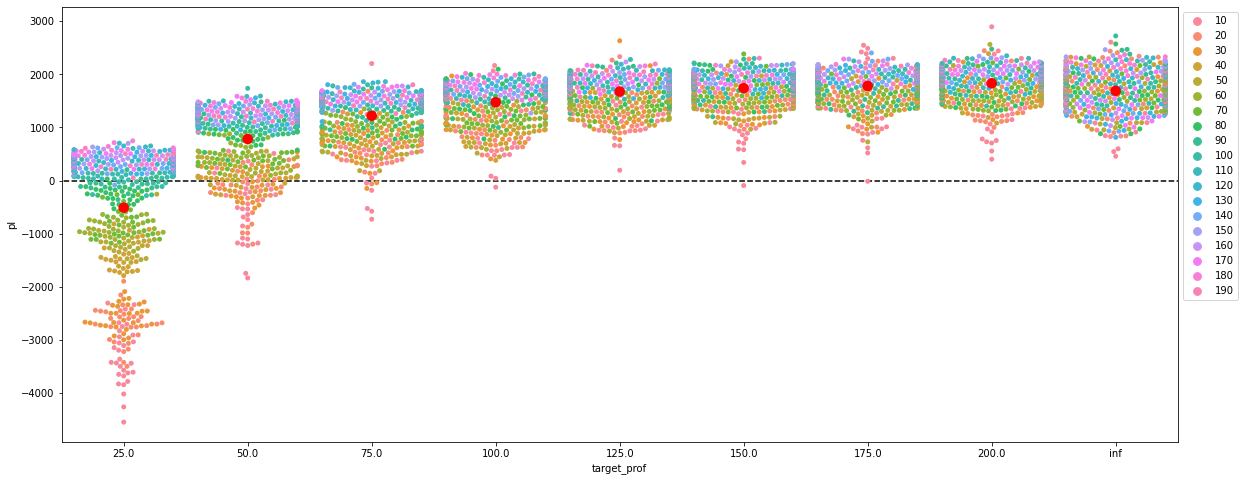

In [6]:
# 目標利益ポイント（target_prof）と総損益（pl）の関係
"""
- 目標利益と総損益は正相関しているが、200と無限大では無限大の方が総損益が小さいため、どこかにピークがある
- 目標利益が小さい条件では最大保有期間と総損益の間に正相関が見られる
- 目標利益を無限大にした場合（つまり常に最大保有期限まで保有する）は最大保有期間と総損益の間に相関は見られない
"""

pl_mean = df.groupby('target_prof')['pl'].mean()

fig = plt.figure(figsize=(20, 8))

ax = sns.pointplot(pl_mean.index, pl_mean, linestyles='', marker='.', color='red', scale=1.2)
# pointplotのzorderはいつも一番小さい値になってしまうらしい。
# seabornではプロット関数の引数にzorder=XXという設定ができないから、以下のようにハックする
# ref: https://stackoverflow.com/questions/32281580/using-seaborn-how-do-i-get-all-the-elements-from-a-pointplot-to-appear-above-th
plt.setp(ax.lines, zorder=100)
plt.setp(ax.collections, zorder=100, label="")

sns.swarmplot('target_prof', 'pl', hue='n_bars', data=df, ax=ax)
ax.plot([-1, 11], [0, 0], color='black', linestyle='--')
plt.legend(bbox_to_anchor=(1,1), loc='upper left')

## 総損益を最大化する条件の探索（各条件別プロット）
上のプロットから、最大保有期間が短い場合は損益が小さいことがわかるので、ここでは最大保有期間が50以上の場合だけを見る

/Users/leo/src/pyscript/traiding-sandbox/.venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


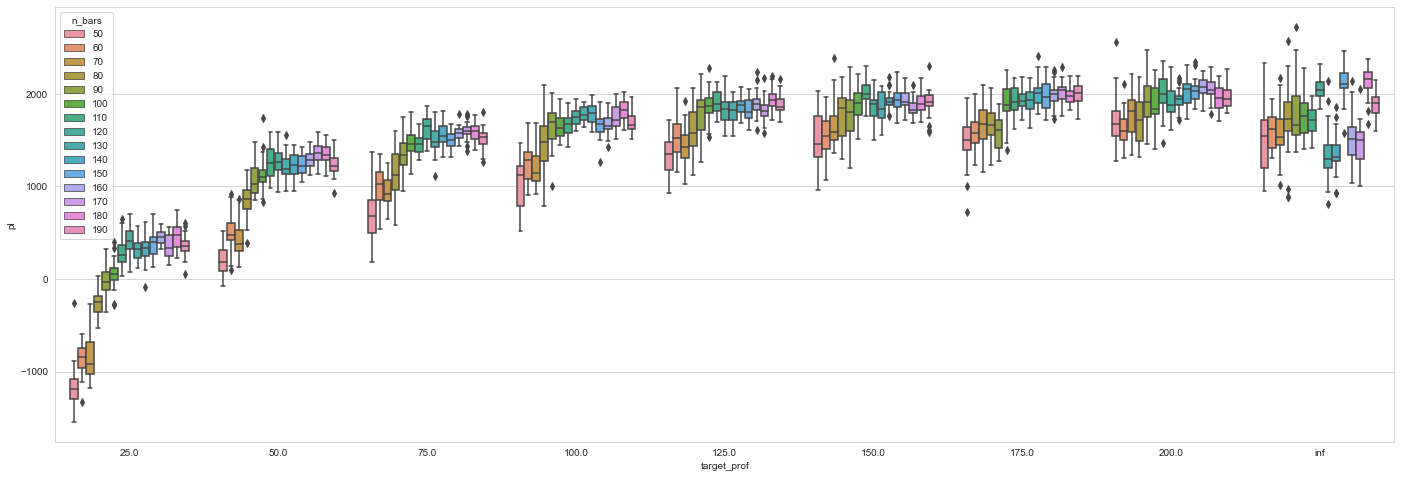

In [9]:
# 目標利益ポイント（target_prof）と総損益（pl） × 最大保有期間（n_bars）の関係
"""
最大保有期間が100までは保有期間と総損益（と総損益のばらつき）の間に正相関が見られる
最大保有期間が100以上では総損益やそのばらつきとの間に相関は見られない
一方、最大保有期間が短いほどトレード回数は多くなるはずだから、1トレードあたりの平均損益は、最大保有期間が100以上でも相関があると予想される
トレード回数が多いほどコスト（取引手数料とスリッページ）が大きくなるため、コストも考慮した場合は最大保有期間が最大の200足の場合に総損益が最大になると示唆される
"""


df_n_bars50 = df[df['n_bars'] >= 50]

plt.figure(figsize=(24, 8))
sns.set_style('whitegrid')
sns.boxplot('target_prof', 'pl', hue='n_bars', data=df_n_bars50)

/Users/leo/src/pyscript/traiding-sandbox/.venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/leo/src/pyscript/traiding-sandbox/.venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/leo/src/pyscript/traiding-sandbox/.venv/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 16.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/leo/src/pyscript/trai

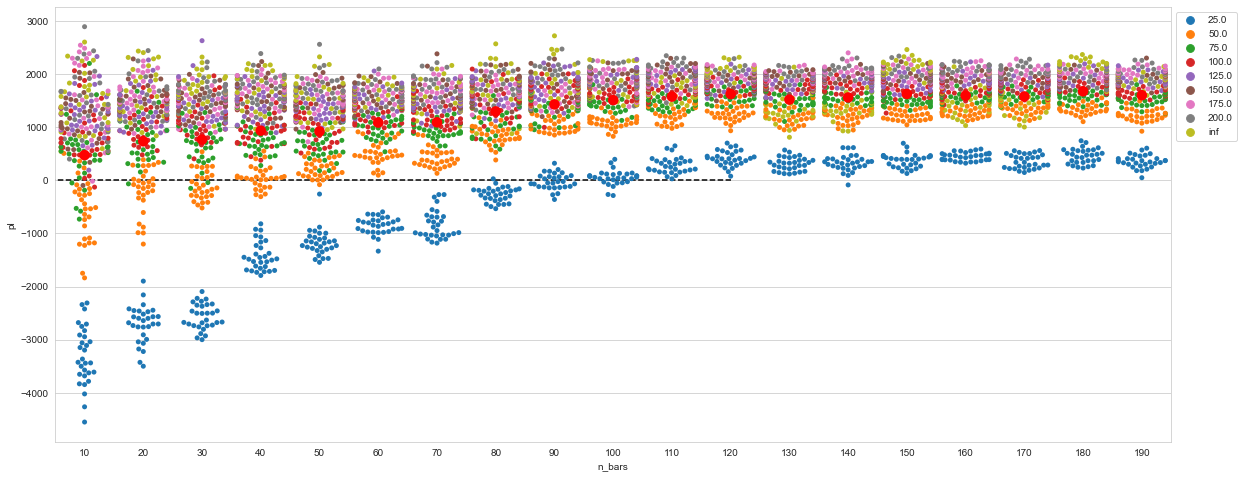

In [8]:
# 最大保有期間と総損益との関係
"""
- 最大保有期間が100を超えたあたりからは総損益との間に相関は見られない
"""
pl_mean = df.groupby('n_bars')['pl'].mean()

fig = plt.figure(figsize=(20, 8))

ax = sns.pointplot(pl_mean.index, pl_mean, linestyles='', marker='.', color='red', scale=1.2)
# pointplotのzorderはいつも一番小さい値になってしまうらしい。
# seabornではプロット関数の引数にzorder=XXという設定ができないから、以下のようにハックする
# ref: https://stackoverflow.com/questions/32281580/using-seaborn-how-do-i-get-all-the-elements-from-a-pointplot-to-appear-above-th
plt.setp(ax.lines, zorder=100)
plt.setp(ax.collections, zorder=100, label="")

sns.swarmplot('n_bars', 'pl', hue='target_prof', data=df, ax=ax)
ax.plot([-1, 11], [0, 0], color='black', linestyle='--')
plt.legend(bbox_to_anchor=(1,1), loc='upper left')

<Figure size 1440x1440 with 0 Axes>

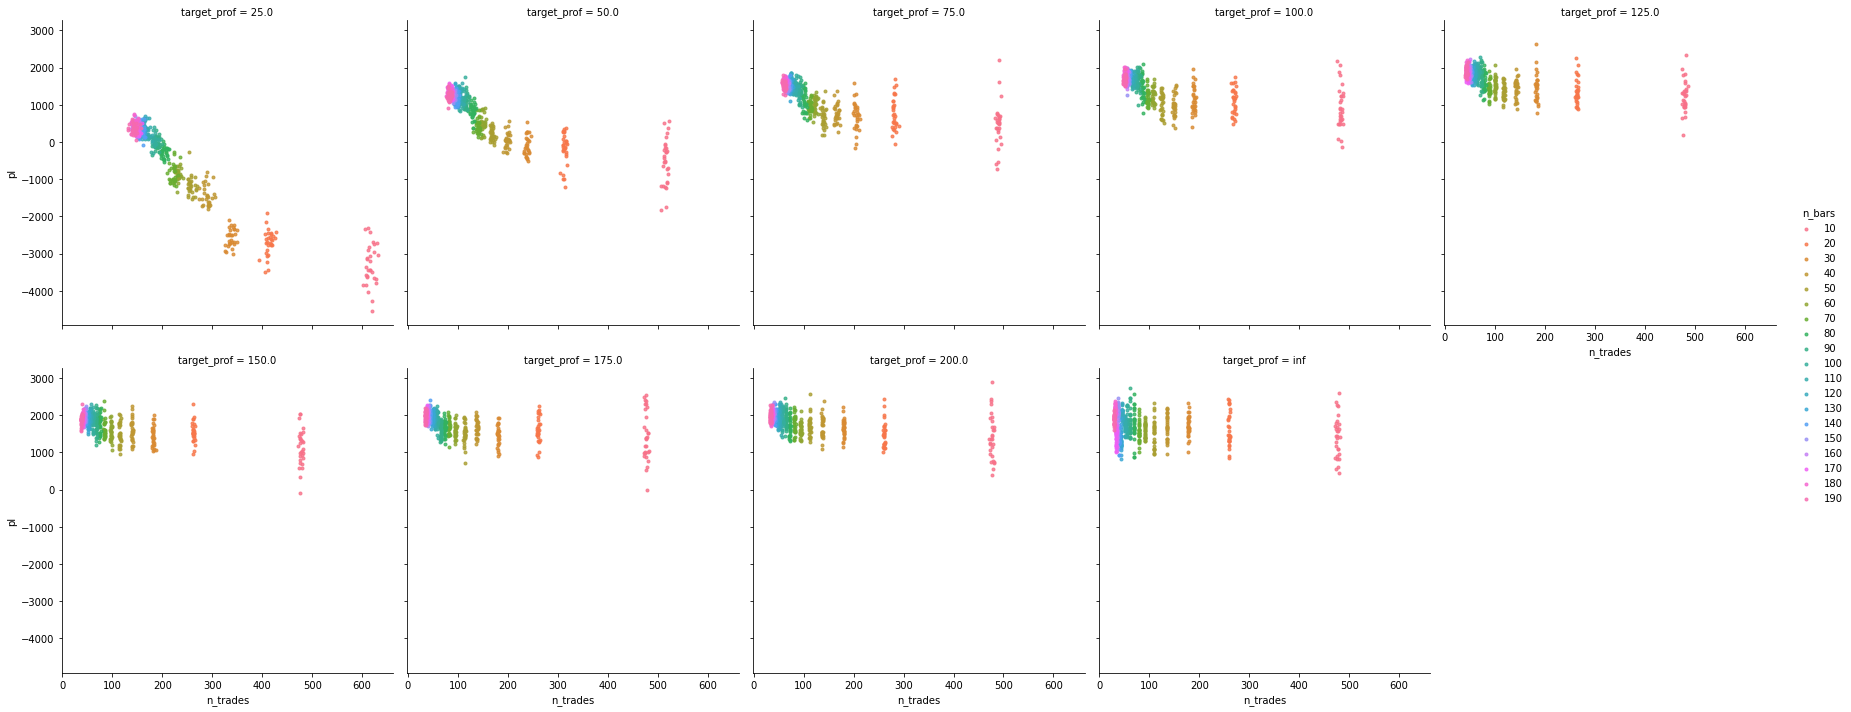

In [7]:
# トレード回数と総損益の関係
"""
- 目標利益が小さい時はトレード回数と総損益の間に負相関が見られるが、目標利益が100以上の条件では相関はほとんど見られない
"""
plt.figure(figsize=(20,20))
sns.lmplot('n_trades', 'pl', hue='n_bars', col='target_prof', col_wrap=5, data=df, fit_reg=False, markers='.')

top 5 of pl mean: [((inf, 180), 2130.825), ((inf, 150), 2121.733333333333), ((200.0, 160), 2061.4333333333334), ((inf, 120), 2056.233333333333), ((200.0, 170), 2049.35)]
max loss in 1 trade when target_prof=50 and n_bars=60: -540.5


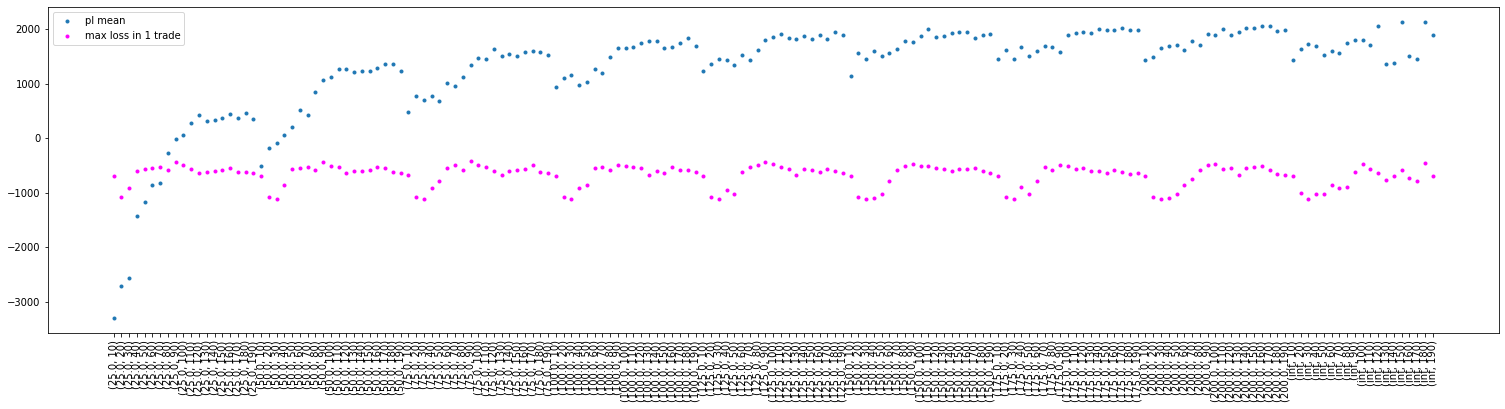

In [9]:
# 目標利益と最大保有期間の条件組み合わせの中で総損益の平均値のランキング
"""
- 目標利益=inf、最大保有期間=180、の時に総損益が最大となった。その時の総損益は2130.825
- しかし目標利益=infの時は最大保有期間ごとの総損益のばらつきが大きいためこの値の信頼性は低い
- その観点では、目標利益が200の時の最大総損益条件である最大保有期間=170という条件の方がばらつきが小さく信頼性が高い。その時の総損益は2049.35
"""
df_mean_2_cond = df.groupby(['target_prof', 'n_bars'])['pl'].mean()
mean_2_cond = sorted(zip(df_mean_2_cond.keys(), df_mean_2_cond.values), key=lambda x: x[1], reverse=True)
print('top 5 of pl mean:', mean_2_cond[:5])

max_loss_in1_mean = df.groupby(['target_prof', 'n_bars'])['max_loss_in1'].min()
print(f'max loss in 1 trade when target_prof=50 and n_bars=60: {max_loss_in1_mean[50, 60]}')

plt.figure(figsize=(26, 6))
plt.plot(range(len(df_mean_2_cond.values)), df_mean_2_cond.values, linestyle='', marker='.', label='pl mean')
plt.plot(range(len(max_loss_in1_mean.values)), max_loss_in1_mean.values, linestyle='', marker='.', color='magenta', label='max loss in 1 trade')
plt.xticks(range(len(df_mean_2_cond.values)), df_mean_2_cond.keys(), rotation=90)
plt.legend()

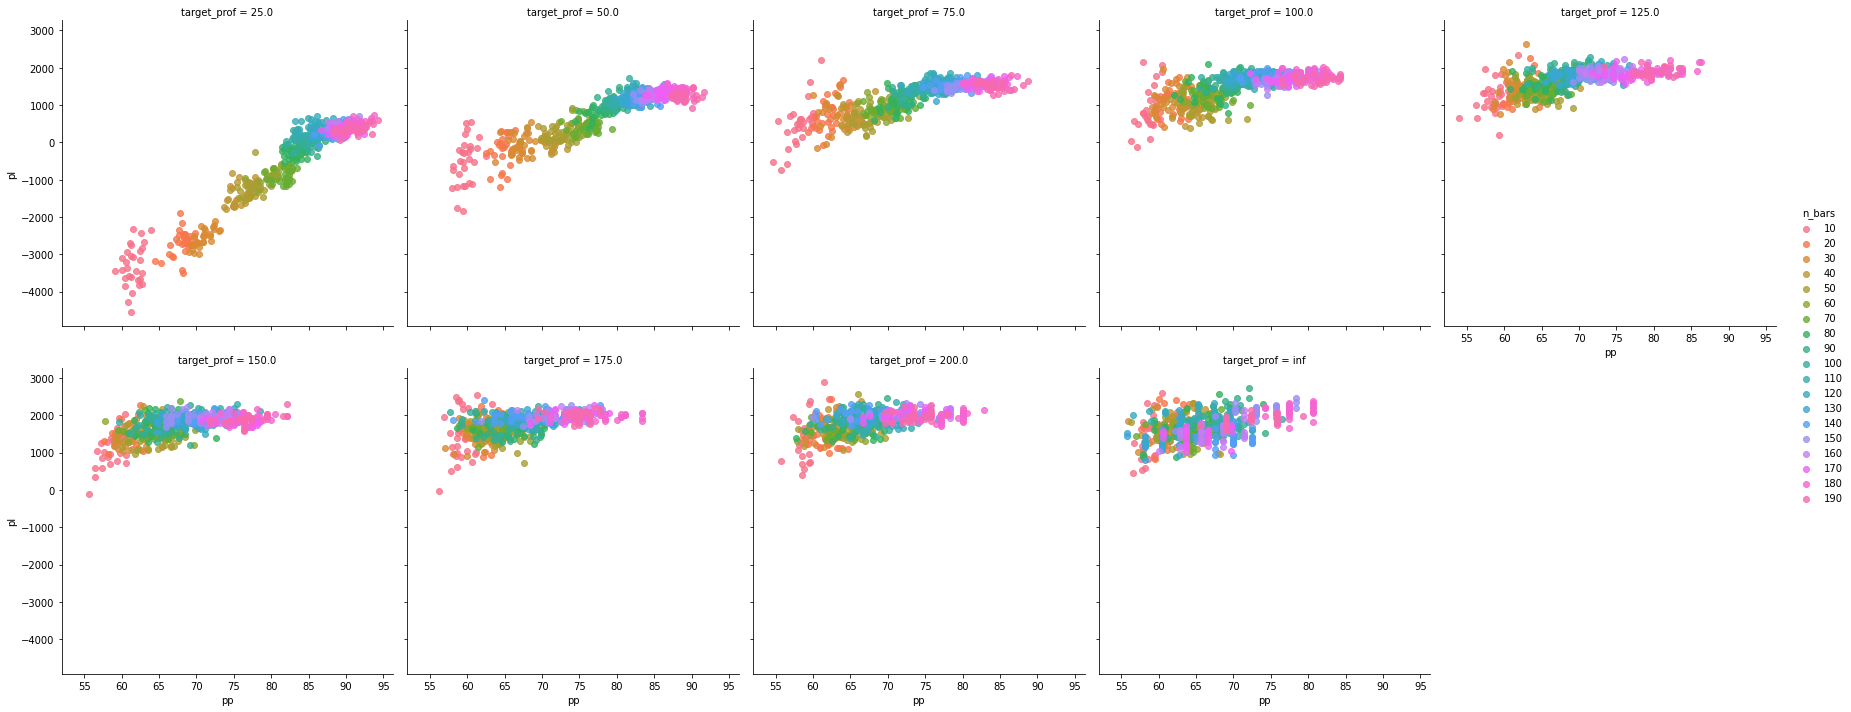

In [12]:
# 勝率と総損益の関係
"""
- 勝率と総損益は正相関
- 最大保有期間と総損益は正相関
- 目標利益が大きいほど勝率と総損益の相関は弱くなる
"""
sns.lmplot('pp', 'pl', hue='n_bars', col='target_prof', col_wrap=5, data=df, fit_reg=False)